In [1]:
!pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=4fa24a4163d1c39a43c451bbc9ba7f24d08842230b958d1ed76e9fad430185be
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy


# Import des données

réalisé avec le dataset SessionAllLayers

In [31]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [96]:
with open("train-images-idx3-ubyte", 'rb') as file:
    data_train = idx2numpy.convert_from_file(file)
print(type(data_train))

<class 'numpy.ndarray'>


In [97]:
with open("train-labels-idx1-ubyte", 'rb') as file:
    label_train = idx2numpy.convert_from_file(file)
print(type(label_train))

<class 'numpy.ndarray'>


In [98]:
with open("test-images-idx3-ubyte", 'rb') as file:
    data_test = idx2numpy.convert_from_file(file)
print(type(data_test))

<class 'numpy.ndarray'>


In [104]:
with open("test-labels-idx1-ubyte", 'rb') as file:
    label_test = idx2numpy.convert_from_file(file)
print(type(label_test))

<class 'numpy.ndarray'>


# Exploration Datas

In [106]:
dico={}
for element in label_test:
  dico[element] = dico.get(element, 0) + 1
dico

{0: 600,
 1: 600,
 2: 600,
 3: 104,
 4: 188,
 5: 600,
 6: 407,
 7: 30,
 8: 102,
 9: 48,
 10: 66,
 11: 600}

In [7]:
nb_classes = len(dico)

# Creation du dataset

## dataset cnn 1d

In [138]:
# Conv 1D
X_1d = tf.reshape(data_train, [-1, 784, 1]) # -1 is to get the lenght of the sample data
X_1d.shape

TensorShape([35501, 784, 1])

In [139]:
y = tf.one_hot(label_train, nb_classes)
y.shape

TensorShape([35501, 12])

In [140]:
ds_1d = tf.data.Dataset.from_tensor_slices((X_1d, y))

In [141]:
n = ds_1d.cardinality().numpy()

ds_1d = ds_1d.shuffle(n, reshuffle_each_iteration=True)
ds_1d = ds_1d.batch(64).prefetch(64).cache()

In [142]:
n_new = ds_1d.cardinality().numpy()

ds_estim_1d = ds_1d.take(int(n_new * 0.8)) # Création du dataset d'estimation
ds_valid_1d = ds_1d.skip(int(n_new * 0.8)).take(int(n_new * 0.2)) # Création du dataset de validation

In [143]:
# Création du dataset de test
X_test_1d = tf.reshape(data_test, [-1, 784, 1])
y_test = tf.one_hot(label_test, nb_classes)
ds_test_1d = tf.data.Dataset.from_tensor_slices((X_test_1d, y_test))
ds_test_1d = ds_test_1d.batch(64).prefetch(64).cache()

## dataset cnn 2d

In [114]:
# Conv 1D
X_2d = tf.reshape(data_train, [-1, 28, 28, 1]) # -1 is to get the lenght of the sample data
X_2d.shape

TensorShape([35501, 28, 28, 1])

In [115]:
ds_2d = tf.data.Dataset.from_tensor_slices((X_2d, y))
n = ds_2d.cardinality().numpy()

ds_2d = ds_2d.shuffle(n, reshuffle_each_iteration=True)
ds_2d = ds_2d.batch(64).prefetch(64).cache()

n_new = ds_2d.cardinality().numpy()

ds_estim_2d = ds_2d.take(int(n_new * 0.8)) # Création du dataset d'estimation
ds_valid_2d = ds_2d.skip(int(n_new * 0.8)).take(int(n_new * 0.2)) # Création du dataset de validation

In [116]:
# Création du dataset de test
X_test_2d = tf.reshape(data_test, [-1, 28, 28, 1])
ds_test_2d = tf.data.Dataset.from_tensor_slices((X_test_2d, y_test))
ds_test_2d = ds_test_2d.batch(64).prefetch(64).cache()

# Modèle

## CNN 1D

In [144]:
def build_CNN_1D(input_dim, output_dim):
  
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Input(shape=input_dim))

  model.add(tf.keras.layers.Conv1D(32, kernel_size=2, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling1D(strides=3, padding='same'))

  model.add(tf.keras.layers.Conv1D(64, kernel_size=2, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling1D(strides=3, padding='same'))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  model.add(tf.keras.layers.Dense(output_dim, activation="softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [145]:
cnn_1d = build_CNN_1D(input_dim=X_1d.shape[1:], output_dim=y.shape[1])
cnn_1d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 784, 32)           96        
                                                                 
 activation_6 (Activation)   (None, 784, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 262, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 262, 64)           4160      
                                                                 
 activation_7 (Activation)   (None, 262, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 88, 64)           0         
 1D)                                                  

In [146]:
epochs = 10
training_1d = cnn_1d.fit(ds_estim_1d, epochs=epochs, validation_data=ds_valid_1d)

Epoch 1/10
444/444 [==============================] - 6s 12ms/step - loss: 4.8412 - accuracy: 0.7764 - val_loss: 0.2902 - val_accuracy: 0.8710
Epoch 2/10
444/444 [==============================] - 5s 11ms/step - loss: 0.2812 - accuracy: 0.8857 - val_loss: 0.2023 - val_accuracy: 0.9331
Epoch 3/10
444/444 [==============================] - 5s 12ms/step - loss: 0.1887 - accuracy: 0.9271 - val_loss: 0.1712 - val_accuracy: 0.9438
Epoch 4/10
444/444 [==============================] - 5s 11ms/step - loss: 0.1379 - accuracy: 0.9471 - val_loss: 0.1542 - val_accuracy: 0.9440
Epoch 5/10
444/444 [==============================] - 5s 11ms/step - loss: 0.1045 - accuracy: 0.9633 - val_loss: 0.1579 - val_accuracy: 0.9393
Epoch 6/10
444/444 [==============================] - 6s 14ms/step - loss: 0.0938 - accuracy: 0.9653 - val_loss: 0.1340 - val_accuracy: 0.9447
Epoch 7/10
444/444 [==============================] - 5s 12ms/step - loss: 0.0881 - accuracy: 0.9670 - val_loss: 0.1163 - val_accuracy: 0.9620

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


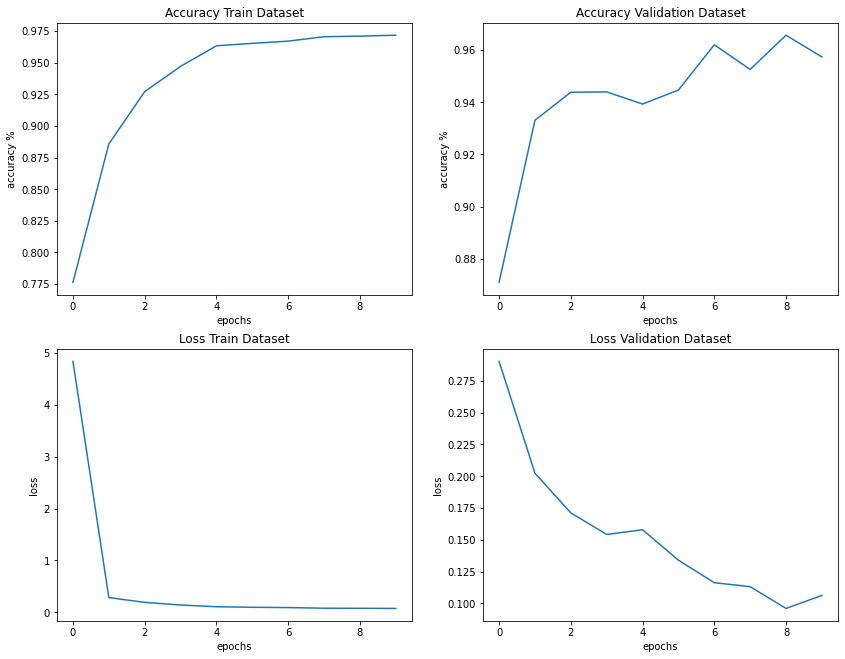

In [147]:
print(training_1d.history.keys())
estim_acc = training_1d.history['accuracy']
valid_acc = training_1d.history['val_accuracy']
estim_loss = training_1d.history['loss']
valid_loss = training_1d.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [149]:
cnn_1d.evaluate(ds_test_1d)

62/62 [==============================] - 1s 8ms/step - loss: 0.1145 - accuracy: 0.9577


[0.11450007557868958, 0.9576679468154907]

In [148]:
cnn_1d.save('cnn_1d.h5')

## CNN 2D

In [117]:
def build_CNN_2D(input_dim, output_dim):
  
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Input(shape=input_dim))

  model.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(strides=2, padding='same'))

  model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same'))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D(strides=2, padding='same'))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1024))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  model.add(tf.keras.layers.Dense(output_dim, activation="softmax"))

  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.95, beta_2 = 0.999, epsilon = 1e-08)
  loss = tf.keras.losses.CategoricalCrossentropy()
  accuracy = tf.keras.metrics.Accuracy()

  model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

  return model

In [118]:
cnn_2d = build_CNN_2D(input_dim=X_2d.shape[1:], output_dim=y.shape[1])
cnn_2d.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 activation_4 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 activation_5 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [119]:
epochs = 10
training_2d = cnn_2d.fit(ds_estim_2d, epochs=epochs, validation_data=ds_valid_2d)

Epoch 1/10
444/444 [==============================] - 6s 12ms/step - loss: 1.8713 - accuracy: 0.7071 - val_loss: 0.5177 - val_accuracy: 0.7608
Epoch 2/10
444/444 [==============================] - 6s 13ms/step - loss: 0.4744 - accuracy: 0.7870 - val_loss: 0.4251 - val_accuracy: 0.8104
Epoch 3/10
444/444 [==============================] - 6s 14ms/step - loss: 0.3970 - accuracy: 0.8158 - val_loss: 0.3938 - val_accuracy: 0.8174
Epoch 4/10
444/444 [==============================] - 6s 13ms/step - loss: 0.3558 - accuracy: 0.8287 - val_loss: 0.3652 - val_accuracy: 0.8289
Epoch 5/10
444/444 [==============================] - 6s 13ms/step - loss: 0.3257 - accuracy: 0.8400 - val_loss: 0.3466 - val_accuracy: 0.8402
Epoch 6/10
444/444 [==============================] - 7s 15ms/step - loss: 0.3070 - accuracy: 0.8464 - val_loss: 0.3487 - val_accuracy: 0.8349
Epoch 7/10
444/444 [==============================] - 6s 14ms/step - loss: 0.2954 - accuracy: 0.8493 - val_loss: 0.3326 - val_accuracy: 0.8382

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


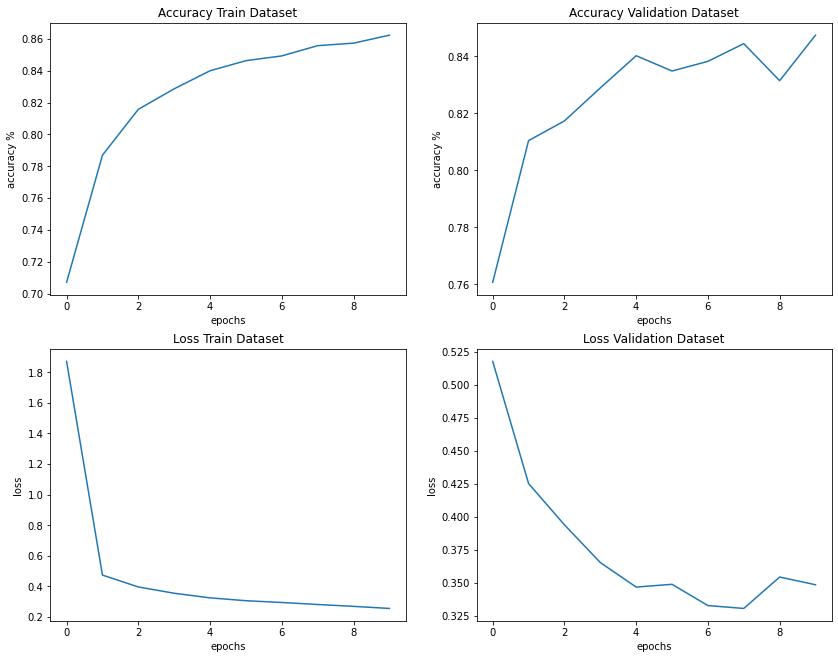

In [120]:
print(training_2d.history.keys())
estim_acc = training_2d.history['accuracy']
valid_acc = training_2d.history['val_accuracy']
estim_loss = training_2d.history['loss']
valid_loss = training_2d.history['val_loss']

### Plots
plt.figure(figsize=(14,11))
plt.subplot(2,2,1)
plt.plot(estim_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Train Dataset')
plt.subplot(2,2,2)
plt.plot(valid_acc)
plt.ylabel('accuracy %') 
plt.xlabel('epochs') 
plt.title('Accuracy Validation Dataset') 
plt.subplot(2,2,3)
plt.plot(estim_loss)
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Loss Train Dataset') 
plt.subplot(2,2,4)
plt.plot(valid_loss)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss Validation Dataset') 
plt.show()

In [126]:
cnn_2d.evaluate(ds_test_2d)

62/62 [==============================] - 0s 6ms/step - loss: 0.3484 - accuracy: 0.8527


[0.3483831584453583, 0.8527249693870544]

In [125]:
cnn_2d.save('cnn_2d.h5')

# Evaluation modèle

In [127]:
tags = ["Chat", "Streaming", "FileTransfer", "P2P", "Email", "VoIP", 
        "VPN-Chat", "VPN-Streaming", "VPN-FileTransfer", "VPN-P2P", "VPN-Email", "VPN-VoIP"]

In [128]:
def plot_conf_matrix(cf_matrix):
  """
  fonction permettant d'afficher la matrice de confusion
  """
  plt.figure(figsize=(14,11))

  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

  ax.set_title('Confusion Matrix with labels\n');
  ax.set_xlabel('\nPredicted Entity Category')
  ax.set_ylabel('Actual Entity Category ');

  ax.xaxis.set_ticklabels(tags)
  ax.yaxis.set_ticklabels(tags)

  plt.savefig('cf_matrix.png')

  plt.show()

In [129]:
prediction_raw = cnn_2d.predict(ds_test_2d)

In [132]:
L_preds, L_labels = [], label_test.tolist()

for output in prediction_raw:
  L_preds.append(tf.math.argmax(output, 0).numpy())

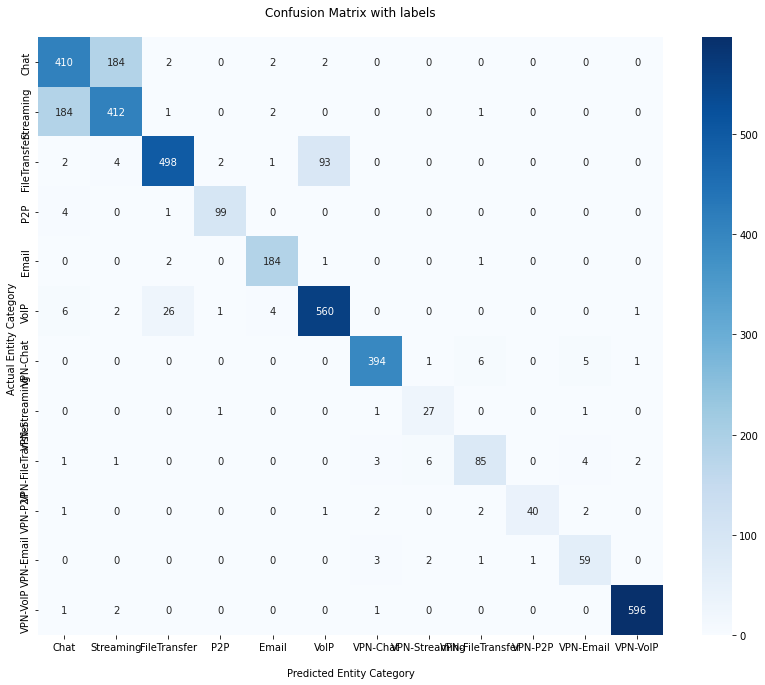

In [134]:
cf_matrix = tf.math.confusion_matrix(L_labels, L_preds , num_classes=nb_classes)
plot_conf_matrix(cf_matrix)

In [135]:
recall = np.diag(cf_matrix) / np.sum(cf_matrix, axis = 1)
precision = np.diag(cf_matrix) / np.sum(cf_matrix, axis = 0)

In [136]:
recall_mean = np.mean(recall)
precision_mean = np.mean(precision)
f2_measure = 2*(recall_mean * precision_mean)/(recall_mean + precision_mean)

print('Précision globale du modèle \n')
print('recall : ', recall_mean)
print('precision : ', precision_mean)
print('F2-measure : ', f2_measure)

Précision globale du modèle 

recall :  0.8738315147091744
precision :  0.8726112097725345
F2-measure :  0.8732209359044744
